<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/14_12_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.6 MB/s eta 0:00:00


## 14.12 Neural Style Transfer

### 14.12.2 Reading the Content and Style Image

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

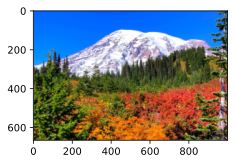

In [13]:
d2l.set_figsize()
content_img = d2l.Image.open('rainer.jpg')
d2l.plt.imshow(content_img);

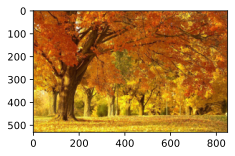

In [14]:
style_img = d2l.Image.open('autumn-oak.jpg')
d2l.plt.imshow(style_img);

### 14.12.3 Preprocessing and Postprocessing

In [15]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose([
      torchvision.transforms.Resize(image_shape),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
  return transforms(img).unsqueeze(0)

def postprocess(img):
  img = img[0].to(rgb_std.device)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### 14.12.4 ٍExtracting Features

In [16]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 59.4MB/s]


In [17]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [18]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [19]:
def extract_features(X, content_layers, style_layers):
  contents = []
  styles = []
  for i in range(len(net)):
    X = net[i](X)
    if i in style_layers:
      styles.append(X)
    if i in content_layers:
      contents.append(X)
  return contents, styles

In [20]:
def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)
  return content_X, contents_Y

def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(style_X, content_layers, style_layers)
  return style_X, styles_Y


### 14.12.5 Defining the Loss Function

#### Content Loss

In [21]:
def content_loss(Y_hat, Y):
  return torch.square(Y_hat - Y.detach()).mean()

#### Style Loss

In [22]:
def gram(X):
  num_channels, n = X.shape[1], X.numel() // X.shape[1]
  X = X.reshape((num_channels, n))
  return torch.matmul(X, X.T) / (num_channels * n)

In [23]:
def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### Total Variation Loss

In [24]:
def tv_loss(Y_hat):
  return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#### Loss Function

In [25]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
  contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
      contents_Y_hat, contents_Y)]
  styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
      styles_Y_hat, styles_Y_gram)]
  tv_l = tv_loss(X) * tv_weight

  # Add up all the losses
  l = sum(styles_l + contents_l + [tv_l])
  return contents_l, styles_l, tv_l, l

### 14.12.6 Initializing the Synthesized Image

In [26]:
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape, **kwargs):
    super(SynthesizedImage, self).__init__(**kwargs)
    self.weight = nn.Parameter(torch.rand(*img_shape))

  def forward(self):
    return self.weight

In [27]:
def get_inits(X, device, lr, styles_Y):
  gen_img = SynthesizedImage(X.shape).to(device)
  gen_img.weight.data.copy_(X.data)
  trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
  styles_Y_gram = [gram(Y) for Y in styles_Y]
  return gen_img(), styles_Y_gram, trainer

### 14.12.7 Training

In [28]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
  X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                          xlim=[10, num_epochs],
                          legend=['content', 'style', 'TV'],
                          ncols=2, figsize=(7, 2.5))
  for epoch in range(num_epochs):
    trainer.zero_grad()
    contents_Y_hat, styles_Y_hat = extract_features(
        X, content_layers, style_layers)
    contents_l, styles_l, tv_l, l = compute_loss(
        X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
    l.backward()
    trainer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
      animator.axes[1].imshow(postprocess(X))
      animator.add(epoch + 1, [float(sum(contents_l)),
                               float(sum(styles_l)), float(tv_l)])
  return X

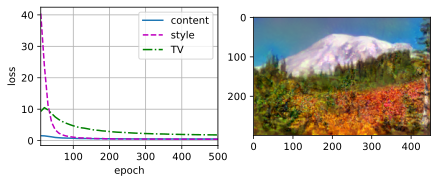

In [29]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)